The Variational Autoencoder (VAE) is a type of deep generative model that can learn to encode high-dimensional data, such as images, into a low-dimensional latent space and then decode that latent representation back to the original data space. A VAE is particularly useful in imaging data, as it can capture meaningful features in a compressed form, making it easier to analyze patterns, generate new images, or explore variations in the data.

**What Does a Simple VAE Do?**
* Encoder:

    The encoder maps the input image into a latent space by compressing it into a lower-dimensional representation.
    Unlike a traditional autoencoder, which might produce a fixed vector, the VAE encoder outputs two components for each latent dimension: a mean and a log variance. These parameters define a Gaussian distribution over the latent space for each input.

* Latent Space Sampling:

    After the encoder produces a mean and variance, a sample is drawn from this Gaussian distribution, which allows the VAE to introduce some randomness or variability into the latent representation.
    The sampling process makes the VAE a generative model, enabling it to create new images by sampling different points in the latent space.

* Decoder:

    The sampled latent vector is then fed to the decoder, which reconstructs the image.
    The decoder tries to reproduce the original input as accurately as possible, allowing the VAE to learn a compressed, yet informative, representation of the input data.
* Loss Function:

    The VAE optimizes two components:
    Reconstruction Loss: Measures the similarity between the input image and the reconstructed image, encouraging the VAE to accurately capture image details.
    KL Divergence: Regularizes the latent space, ensuring the learned latent distributions are close to a standard Gaussian. This keeps the latent space smooth, meaning that similar points in the latent space correspond to similar reconstructed images.

In [1]:
from atomai import stat as atomstat
import atomai as aoi

import numpy as np
import pyroved as pv

import torch
import random
tt = torch.tensor

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic=True
np.random.seed(0)
random.seed(0)

import os
import wget
from sklearn.preprocessing import StandardScaler
import h5py
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from skimage import feature
import skimage
from scipy.ndimage import zoom
from matplotlib.patches import Rectangle
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

import ipywidgets
import pickle

In [2]:
# Load the lists from the pickle file
images_data = "images_data.pkl"

with open(images_data, "rb") as f:
    selected_images, ground_truth_px, ground_truth_py = pickle.load(f)

# Confirm successful loading by checking the lengths of the lists
print(len(selected_images), len(ground_truth_px), len(ground_truth_py))

5 5 5


In [3]:
# min-max normalization:
def norm2d(img: np.ndarray) -> np.ndarray:
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [4]:
image = selected_images[0]
img = norm2d(image)

In [5]:
def custom_extract_subimages(imgdata, coordinates, w_prime):
    # Stage 1: Extract subimages with a fixed size (64x64)
    large_window_size = (64, 64)
    half_height_large = large_window_size[0] // 2
    half_width_large = large_window_size[1] // 2
    subimages_largest = []
    coms_largest = []

    for coord in coordinates:
        cx = int(np.around(coord[0]))
        cy = int(np.around(coord[1]))
        top = max(cx - half_height_large, 0)
        bottom = min(cx + half_height_large, imgdata.shape[0])
        left = max(cy - half_width_large, 0)
        right = min(cy + half_width_large, imgdata.shape[1])

        subimage = imgdata[top:bottom, left:right]
        if subimage.shape[0] == large_window_size[0] and subimage.shape[1] == large_window_size[1]:
            subimages_largest.append(subimage)
            coms_largest.append(coord)

    # Stage 2: Use these centers to extract subimages of window size `w1`
    half_height = w_prime[0] // 2
    half_width = w_prime[1] // 2
    subimages_target = []
    coms_target = []

    for coord in coms_largest:
        cx = int(np.around(coord[0]))
        cy = int(np.around(coord[1]))
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, imgdata.shape[0])
        left = max(cy - half_width, 0)
        right = min(cy + half_width, imgdata.shape[1])

        subimage = imgdata[top:bottom, left:right]
        if subimage.shape[0] == w_prime[0] and subimage.shape[1] == w_prime[1]:
            subimages_target.append(subimage)
            coms_target.append(coord)

    return np.array(subimages_target), np.array(coms_target)

In [6]:
def build_descriptor(window_size, min_sigma, max_sigma, threshold, overlap):

    processed_img = img

    all_atoms = skimage.feature.blob_log(processed_img, min_sigma, max_sigma, 30, threshold, overlap)
    coordinates = all_atoms[:, : -1]
    # Extract subimages
    subimages_target, coms_target = custom_extract_subimages(processed_img, coordinates, window_size)
    # Build descriptors
    descriptors = [subimage.flatten() for subimage in subimages_target]
    descriptors = np.array(descriptors)

    return descriptors, coms_target, all_atoms, coordinates, subimages_target

Now we know the optimum hyperparameters 

In [7]:
window_size = (40,40)
min_sigma = 1
max_sigma = 5
threshold = 0.025
overlap = 0.0
descriptors, coms_target, all_atoms, coordinates, subimages_target = build_descriptor(window_size, min_sigma, max_sigma, threshold, overlap)

In [8]:
print(descriptors.shape)
print(coms_target.shape)
print(all_atoms.shape)
print(coordinates.shape)
print(subimages_target.shape)

(10917, 1600)
(10917, 2)
(11813, 3)
(11813, 2)
(10917, 40, 40)


In [9]:
#normalize imagestack
subimages_target = subimages_target/subimages_target.max()
subimages_target = np.expand_dims(subimages_target, axis=-1)
train_data = torch.tensor(subimages_target[:,:,:,0]).float()
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=48, seed=0)

Now, running the VAE in PyroVEd. Simple VAE will find the best representation of our data as two components for latent vecotr (l1,l2). Of course, we can explore other dimensinalities of latent space!

In [10]:
# in_dim = (window_size[0],window_size[1])

# # Initialize vanilla VAE
# vae = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
#                      hidden_dim_e = [512, 512],
#                      hidden_dim_d = [512, 512], # corresponds to the number of neurons in the hidden layers of the decoder
#                      invariances=None, seed=0)
# # Initialize SVI trainer
# trainer = pv.trainers.SVItrainer(vae)

# # Train for n epochs:
# for e in range(10):
#     trainer.step(train_loader)
#     trainer.print_statistics()

# torch.save(vae.state_dict(), "vae_model.pth")
# print("Model saved successfully.")

In [11]:
in_dim = (window_size[0],window_size[1])

# Reinitialize the model before loading weights
vae_model = pv.models.iVAE(in_dim, latent_dim=2, 
                            hidden_dim_e=[512, 512],
                            hidden_dim_d=[512, 512], 
                            invariances=None, seed=0)

# Load the saved model weights
vae_model.load_state_dict(torch.load("vae_model.pth"))

# Set model to evaluation mode
vae_model.eval()

print("Model loaded successfully.")

Model loaded successfully.


/var/folders/vg/6nvxw8xn77s4z_kb5c3hz38w0000gp/T/ipykernel_596/2399097461.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("vae_mode

Varitional Auto Encoder manifold representation

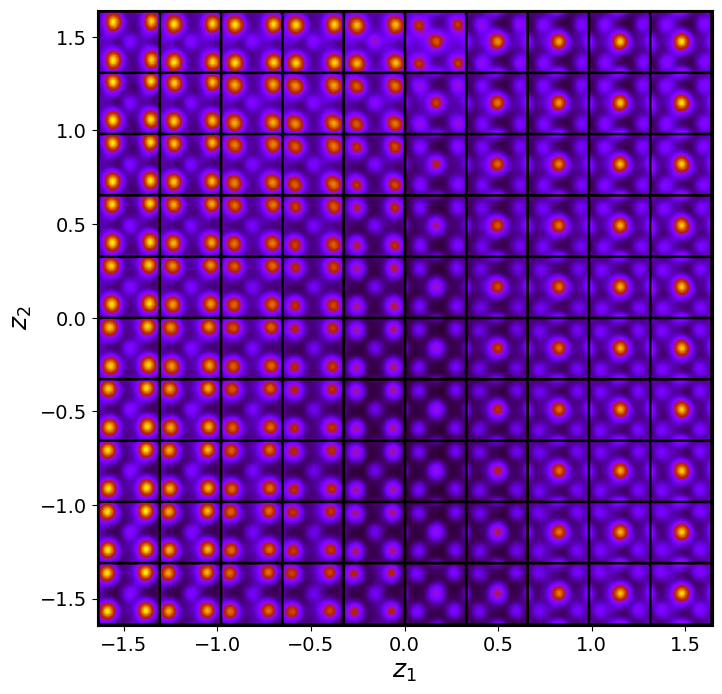

In [12]:
vae_laten_img = vae_model.manifold2d(d=10, draw_grid = True, origin = 'lower')

The latent representation of the system is visualized as a grid over the two latent variables $z_1$ and $z_2$. Each grid cell corresponds to a unique combination of values for $z_1$ and $z_2$ , which are decoded to produce corresponding reconstructions in the data space. The smooth and structured transition across the grid indicates that the model has learned a meaningful and continuous mapping between the latent variables and the data space. Variations in the grid reflect changes in the underlying physical structure, such as column type, domain orientation, or material properties.

In [13]:
vae_z_mean, vae_z_sd = vae_model.encode(train_data)
z1 = vae_z_mean[:, -2]
z2 = vae_z_mean[:, -1]

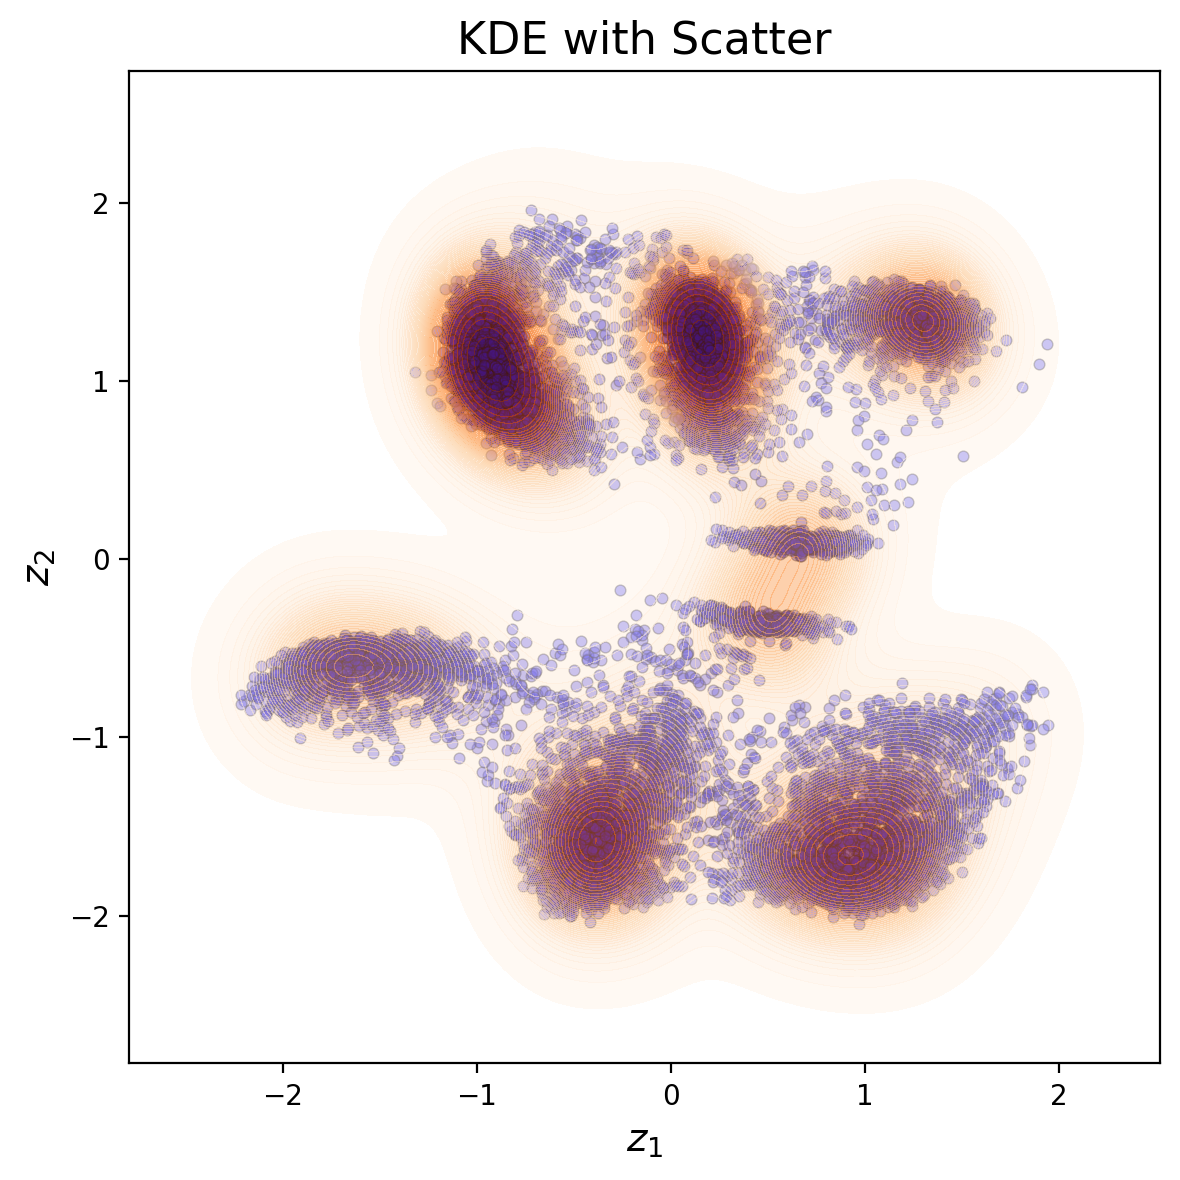

In [14]:
# Plot
plt.figure(figsize=(6, 6), facecolor='white', dpi=200)

# Scatterplot
plt.scatter(z1, z2, s=15, edgecolor='k', linewidth=0.5, alpha=0.4, c="b")

# KDE plot
sns.kdeplot(x=z1, y=z2, cmap="Oranges", levels=50, thresh=0.005, alpha=0.5, fill=True)

# Labels and title
plt.xlabel(r"$z_1$", fontsize=14)
plt.ylabel(r"$z_2$", fontsize=14)
plt.title("KDE with Scatter", fontsize=16)

plt.tight_layout()
plt.show()

In [15]:
def generate_latent_manifold(n=10, decoder=None, target_size=(28, 28)):
    """
    Generate a general latent manifold grid over the entire latent space.
    """
    # Define grid bounds across latent space
    grid_x = np.linspace(min(z1), max(z1), n)
    grid_y = np.linspace(min(z2), max(z2), n)

    # Dynamically infer output shape
    sample_input = torch.tensor([[grid_x[0], grid_y[0]]], dtype=torch.float32)
    with torch.no_grad():
        X_decoded = decoder(sample_input)
    decoded_shape = X_decoded.shape[-2:] if len(X_decoded.shape) > 2 else (X_decoded.shape[-1], X_decoded.shape[-1])

    height, width = target_size
    manifold = np.zeros((height * n, width * n))

    # Generate manifold
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            Z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
            with torch.no_grad():
                X_decoded = decoder(Z_sample).reshape(decoded_shape)
            resized_image = zoom(X_decoded, zoom=(height / X_decoded.shape[-2], width / X_decoded.shape[-1]))
            manifold[i * height: (i + 1) * height, j * width: (j + 1) * width] = resized_image
    return manifold

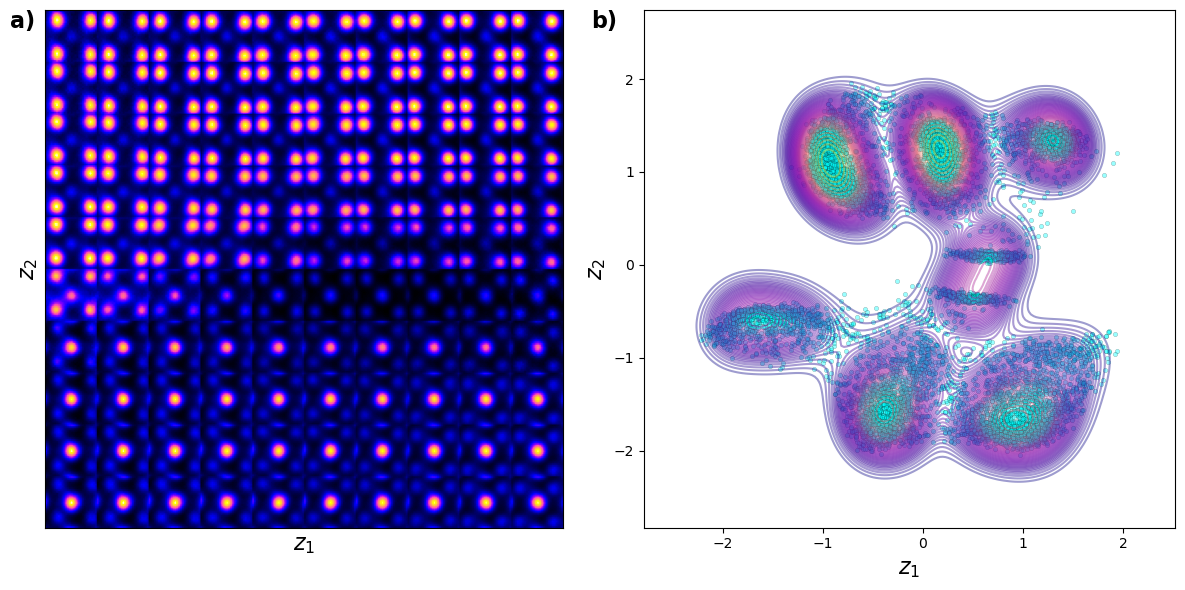

In [ ]:
#| label: app:VAE_manifold_1
# VAE_manifold_1

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate and plot latent manifold
manifold = generate_latent_manifold(n=10, decoder=vae_model.decode, target_size=(28, 28))
axes[0].imshow(manifold, cmap="gnuplot2", origin="upper")

axes[0].set_xlabel(r"$z_1$", fontsize=16, fontweight = "bold")
axes[0].set_ylabel(r"$z_2$", fontsize=16, fontweight = "bold")
axes[0].set_xticks([])
axes[0].set_yticks([])

# Add "a)" to the first subplot
axes[0].text(-0.02, 1, 'a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Scatter and KDE plot using sns
sns.scatterplot(x=z1, y=z2, ax=axes[1], color="cyan", alpha=0.4, edgecolor="k", s=10)
sns.kdeplot(x=z1, y=z2, ax=axes[1], cmap="plasma", levels=50, thresh=0.05, alpha=0.4, fill=False)

axes[1].set_xlabel(r"$z_1$", fontsize=16, fontweight = "bold")
axes[1].set_ylabel(r"$z_2$", fontsize=16, fontweight = "bold")

# Add "b)" to the second subplot
axes[1].text(-0.05, 1, 'b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

In [17]:
Px = ground_truth_px[0]
Py = ground_truth_py[0]

def plot_all_variables(z1, z2, Px, Py, coms_target):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [1.5, 1]})
    
    # Plot z1
    sc1 = axes[0, 0].scatter(coms_target[:, 1], coms_target[:, 0], c=z1, s=14, cmap='jet', marker="o")
    axes[0, 0].set_title("z1", fontsize=16, fontweight="bold")
    axes[0, 0].text(-0.05, 1, 'a)', transform=axes[0, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    axes[0, 0].axis("off")
    
    # Plot z2
    sc2 = axes[0, 1].scatter(coms_target[:, 1], coms_target[:, 0], c=z2, s=14, cmap='jet', marker="o")
    axes[0, 1].set_title("z2", fontsize=16, fontweight="bold")
    axes[0, 1].text(-0.05, 1, 'b)', transform=axes[0, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    axes[0, 1].axis("off")
    
    # Plot Px
    im1 = axes[1, 0].imshow(Px, cmap='jet', origin='lower')
    axes[1, 0].set_title("Ground Truth Px", fontsize=16, fontweight="bold")
    axes[1, 0].text(-0.05, 1, 'c)', transform=axes[1, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    axes[1, 0].axis("off")
    
    # Plot Py
    im2 = axes[1, 1].imshow(Py, cmap='jet', origin='lower')
    axes[1, 1].set_title("Ground Truth Py", fontsize=16, fontweight="bold")
    axes[1, 1].text(-0.05, 1, 'd)', transform=axes[1, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    axes[1, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

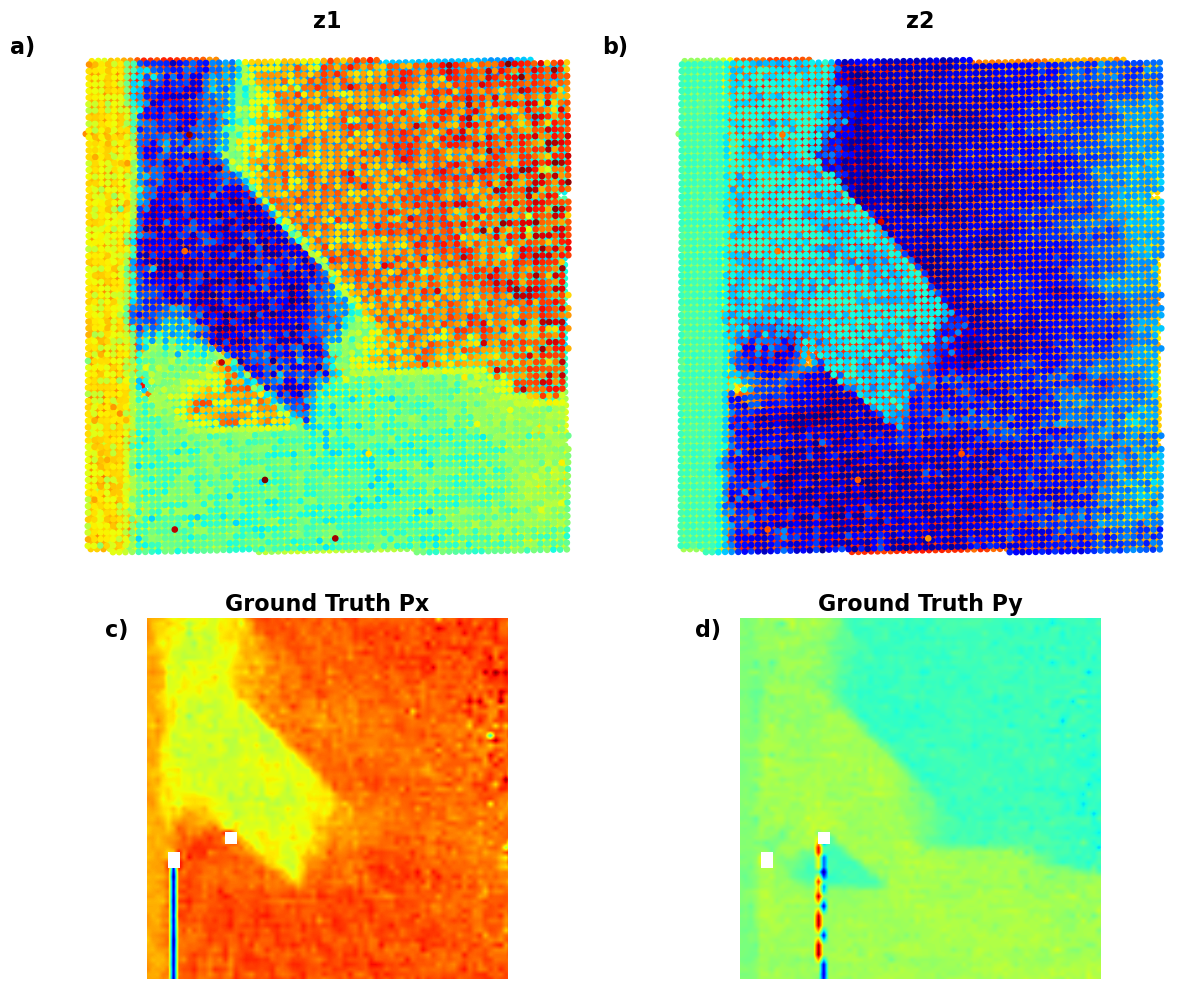

In [ ]:
#| label: app:Latent_maps_2
# Latent_maps_2

plot_all_variables(z1, z2, Px, Py, coms_target)